### Bio Clustering (Word2Vec and Kmeans Clustering)

In [1]:
import pandas as pd
import numpy as np
from time import time
import re
import os
import nltk
import gensim.models.word2vec as w2v

nltk.download("punkt")
nltk.download("stopwords")

from nltk.corpus import stopwords

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import multiprocessing

import seaborn as sns
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt
import sklearn.manifold

from  sklearn.cluster import KMeans
import glob
import gensim 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading file and creating dataframe

In [2]:
file = os.listdir("_data/unlabled/")
file

['bio_1501672304.9134998.txt',
 'bio_1501694930.6841238.txt',
 'bio_1501598612.022413.txt',
 'bio_1501693740.803672.txt']

In [3]:
all_data = []
for i in file:
    with open("_data/unlabled/{}".format(i)) as f:
        temp_data = f.read().split('\n')
    all_data.extend(temp_data)

In [4]:
def clean_sentence(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

In [5]:
df = pd.DataFrame(all_data, columns=['bio'])
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()
df = pd.DataFrame(df['bio'].apply(clean_sentence))
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.count()

bio    44440
dtype: int64

In [6]:
df.describe()

,bio
count,44440
unique,44440
top,traveller actor
freq,1


In [7]:
df['word_freq'] = df['bio'].apply(lambda x: len(x.split()))

#### Average sentence length

In [8]:
df['word_freq'].mean()

10.326597659765977

### Word2Vec Feature Extraction

In [14]:
def sentence_to_wordlist(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text.lower())
    return tokens

In [15]:
sentences = []
for raw_sentence in df['bio']:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [16]:
sentences[909]

['artist', 'voice', 'voiceless']

In [17]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,} tokens".format(token_count))

The corpus contains 459,007 tokens


**Word2Vec model**



In [18]:
# Dimensionality of the resulting word vectors.
# more dimensions mean more training them, but more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3
# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()
# Context window length.
context_size = 7
# Downsample setting for frequent words.
#rate 0 and 1e-5 
#how often to use
downsampling = 1e-3
# Seed for the RNG, to make the results reproducible.
seed = 1

In [19]:
t0 = time()
bio_vec = w2v.Word2Vec(
    sentences,
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling,
    iter = 500
)

print("Train Time:", time()-t0)

Train Time: 984.6213674545288


In [20]:
if not os.path.exists("_data/trained"):
    os.makedirs("_data/trained")

bio_vec.save(os.path.join("_data/trained", "bioVectors.w2v"))

In [21]:
bio_vec.most_similar_cosmul("machine")

[('learning', 0.8550016283988953),
 ('tensorflow', 0.7026152014732361),
 ('simulation', 0.695421040058136),
 ('nlproc', 0.6942228674888611),
 ('emsp', 0.6938009262084961),
 ('algorithms', 0.6917322278022766),
 ('recursecenter', 0.6877003312110901),
 ('nlp', 0.6716901659965515),
 ('curve', 0.6696415543556213),
 ('machinelearning', 0.6660179495811462)]

In [22]:
print("Vocab Size:", len(bio_vec.wv.vocab.keys()))

Vocab Size: 13684


### Visualization and word-D-reduction

In [23]:
t1 = time()
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = bio_vec.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
print("Dimension reduction Time:", time()-t1)

Dimension reduction Time: 522.0278549194336


In [24]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[bio_vec.wv.vocab[word].index])
            for word in bio_vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

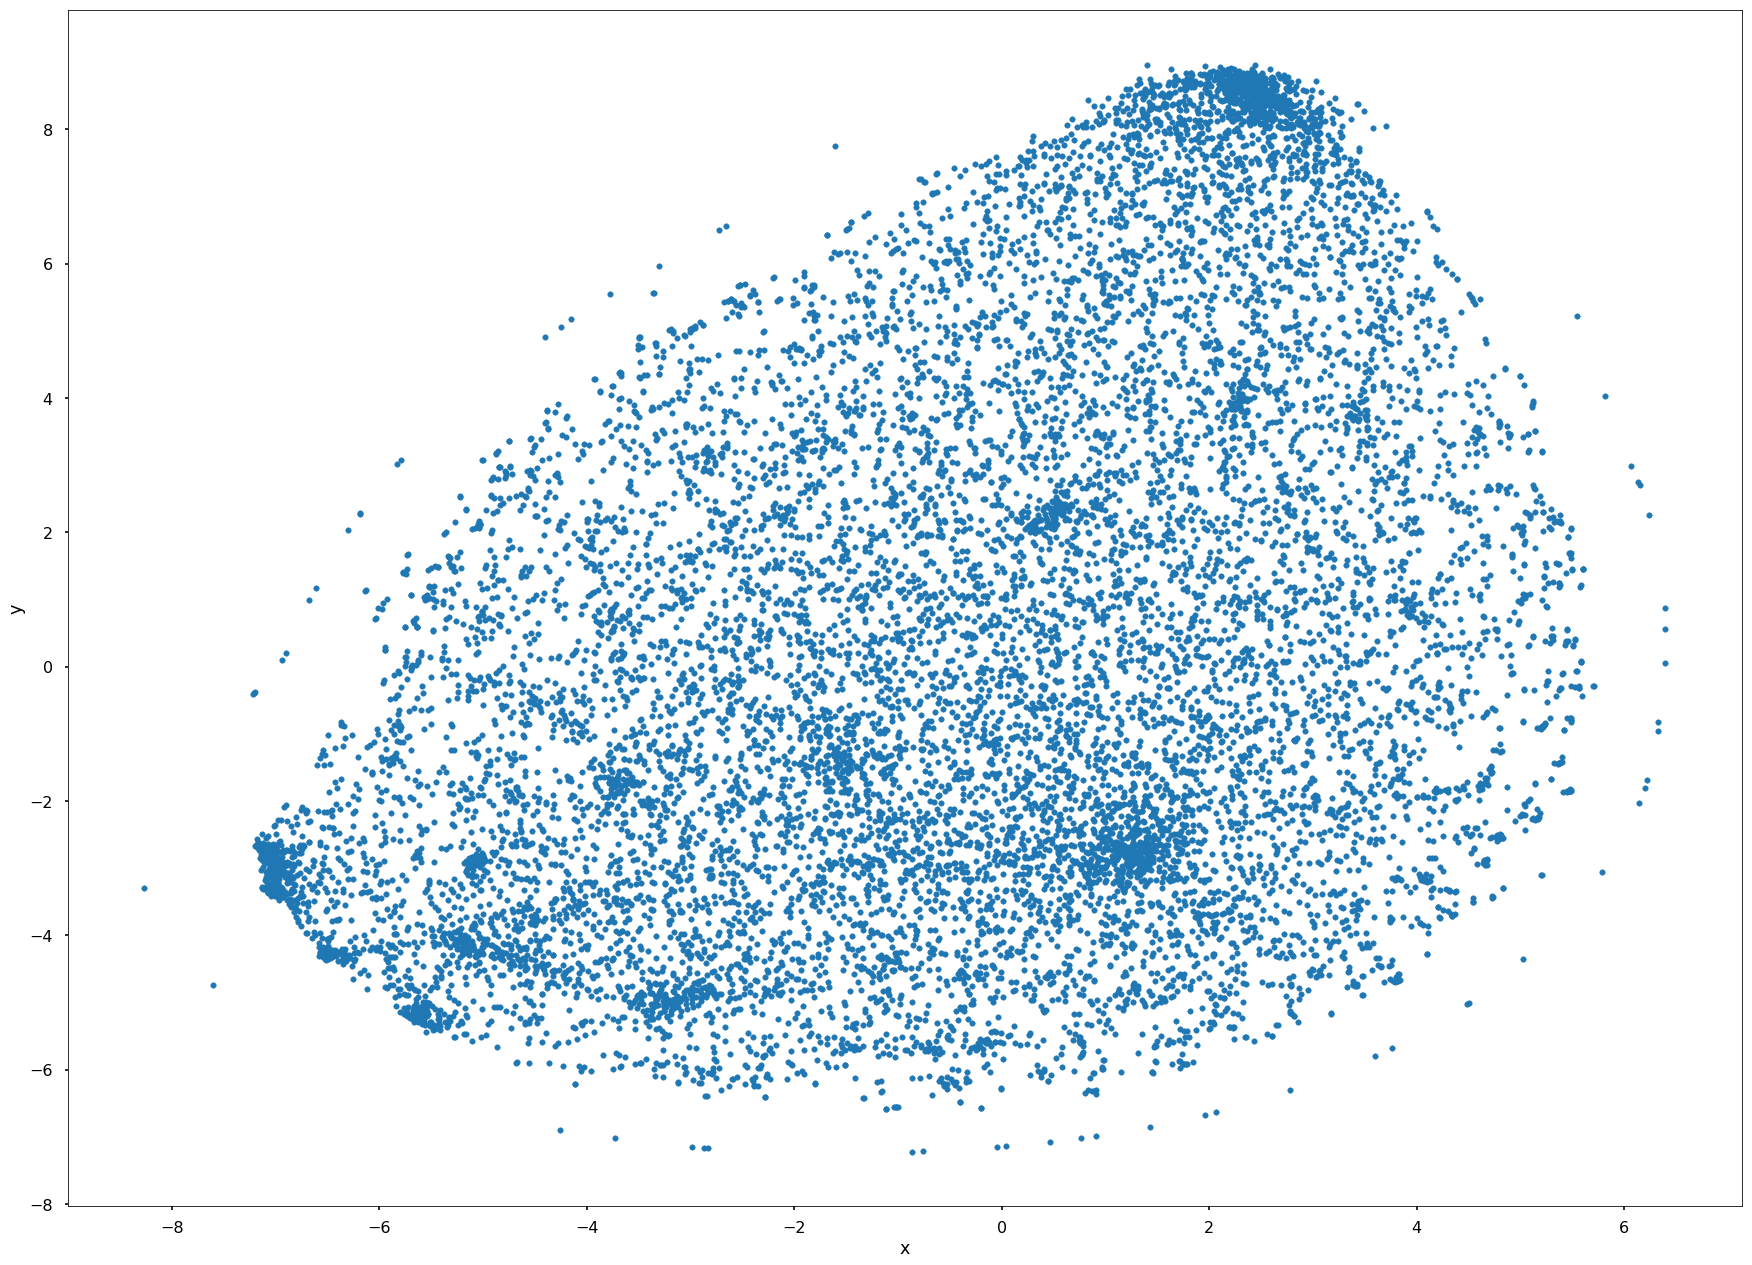

In [25]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=30, figsize=(30, 22))
plt.show()

In [26]:
def plot_region(x_bounds, y_bounds):
    try:
        slice = points[
            (x_bounds[0] <= points.x) &
            (points.x <= x_bounds[1]) & 
            (y_bounds[0] <= points.y) &
            (points.y <= y_bounds[1])
        ]

        ax = slice.plot.scatter("x", "y", s=90, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
    except:
        print("No word in this region")

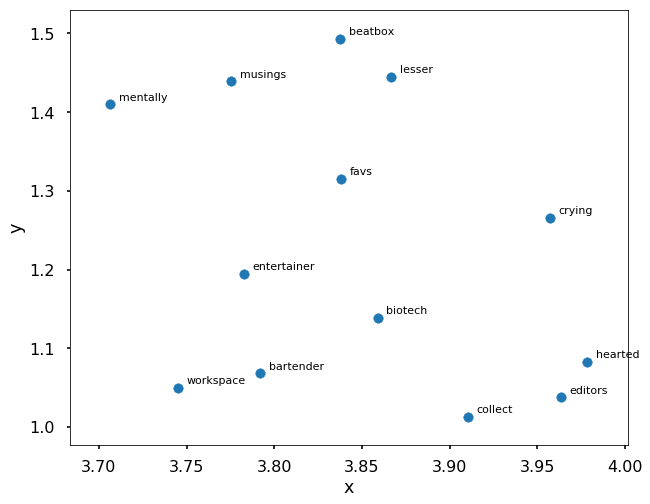

In [35]:
plot_region(x_bounds=(3.6, 4), y_bounds=(1, 1.5))

plt.show()

In [36]:
np.save("_data/trained/reduced_dim", all_word_vectors_matrix_2d)

In [38]:
def kmeans(data, clus):
    km = KMeans(n_clusters=clus, init='k-means++', max_iter=1000, n_init=1,
                    verbose=False)

    print("Clustering sparse data with %s" % km)
    t0 = time()
    km.fit(data)
    print("done in %0.3fs" % (time() - t0))

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1


    plt.figure(figsize=(25, 10))
    plt.scatter(data[:, 0], data[:, 1], s=10, alpha=0.4)

    # Plot the centroids as a white X
    centroids = km.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=90, linewidths=1,
                color='r')
    plt.title('K-means clustering')
    plt.show()
    return km

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=20, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.257s


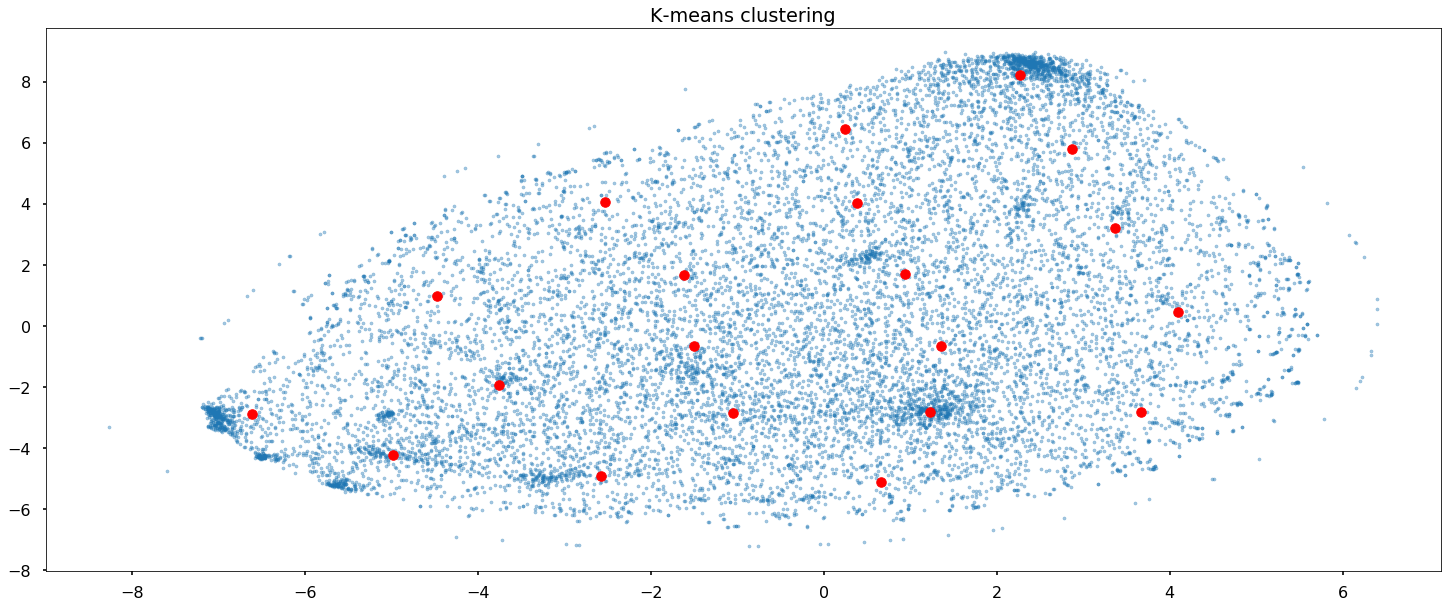

In [42]:
w2v_km = kmeans(all_word_vectors_matrix_2d, 20)

In [43]:
w2v_cluster = {i: points.loc[np.where(w2v_km.labels_ == i)[0]].word for i in range(w2v_km.n_clusters)}

In [44]:
w2v_cluster[0]

76                 gb
220            jaipur
354            bruins
535             daman
843          coursera
913             verse
1033        dietitian
1042              auf
1110            bhatt
1180         students
1188            great
1247            logic
1420         plumbing
1508          ballard
1558             wino
1600          mondays
1624       complicate
1888            other
1889            seize
1933          magical
1941            trips
1973       surprising
1993           roving
2025              utc
2084          washing
2128             kala
2184         contrary
2241          bankers
2271        cambridge
2464           critic
             ...     
13220         obscure
13270             cpi
13278         gurgaon
13300         youtube
13313        retailer
13335      integrated
13376          uplift
13401       perpetual
13426        occupied
13440       galleries
13460           frank
13466        imperium
13470          parent
13491             mha
13496     

### Sentence Embedding and Clustering

In [45]:
def preprocess_text(raw):
    noise_words = []
    stop_words = list(set(stopwords.words('english')))
    URL_REGEX = r"""(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|
                [a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+
                (?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?<>""'']))"""
    raw = re.sub(URL_REGEX, '', raw, flags=re.MULTILINE)
    for n in noise_words:
        clean = raw.replace(n, " ")
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    stop_words = list(set(stopwords.words('english')))
    words = [w for w in words if w not in stop_words]
    tokens = word_tokenize(raw.lower())
    return tokens

In [46]:
def embed_sentences(s):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    for t in sample_text_tokens:
        if t in bio_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, bio_vec[t]])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [47]:
sentence_vectors = np.array([]).reshape(0, 2)

for index, row in df.iterrows():
    sentence_vectors = np.vstack([sentence_vectors, embed_sentences(row['bio'])])

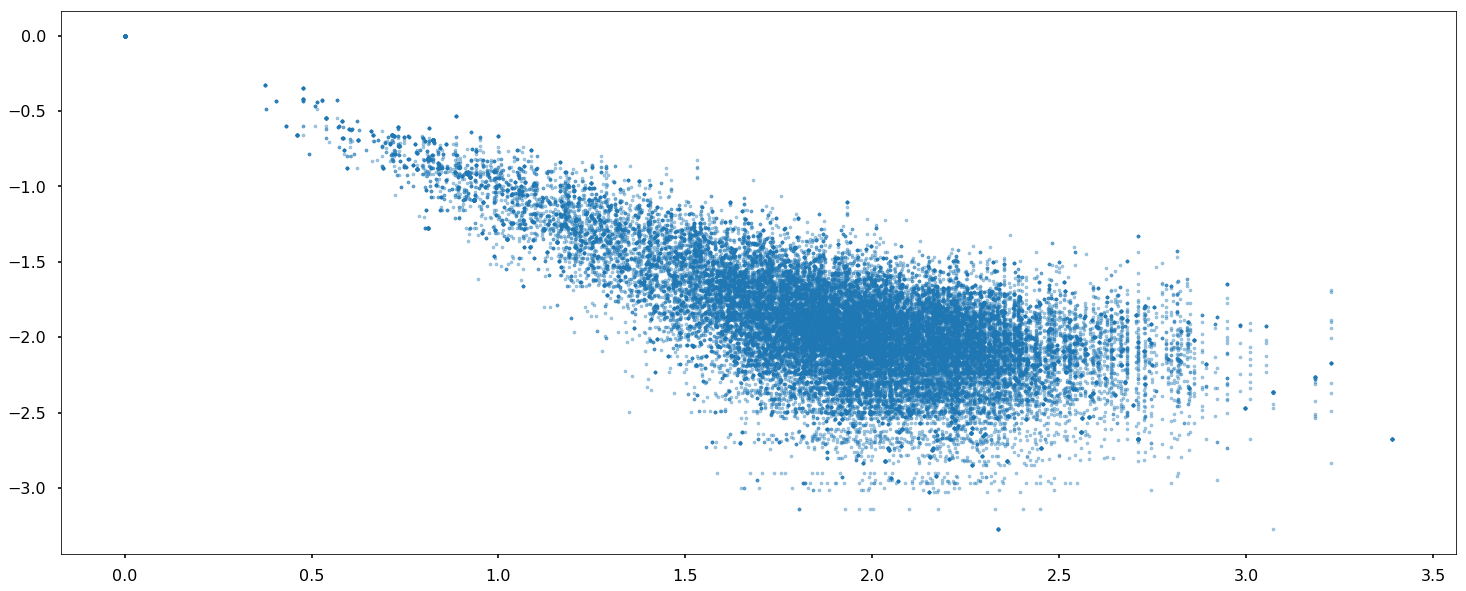

In [48]:
plt.figure(figsize=(25, 10))
plt.scatter([i[0] for i in sentence_vectors], [i[1] for i in sentence_vectors], s=10, alpha=0.4)
plt.show()

### Word2Vec + TfIDF

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=300,
                                 min_df=2, stop_words='english',
                                 use_idf=True)

TfX = vectorizer.fit_transform(df['bio'])

In [51]:
feature_names = vectorizer.get_feature_names()
def get_tfidf_weight(doc):
    feature_index =TfX[doc,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [TfX[doc, x] for x in feature_index])
    result = {}
    for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
        result[w] = s
    return result

In [52]:
get_tfidf_weight(100)

{'culture': 0.63859712849633621,
 'tech': 0.5483881130490118,
 'views': 0.53987423067116092}

In [55]:
def embed_sentences_tfidf_weight(s, doc):
    sample_text_tokens = preprocess_text(s)
    word_vectors = np.array([]).reshape(0, 300)
    word_weights = get_tfidf_weight(doc)
    vector_weight = 1
    for t in sample_text_tokens:
        if t in word_weights:
            vector_weight = word_weights[t]
        if t in bio_vec.wv.vocab.keys():
            word_vectors = np.vstack([word_vectors, np.add(vector_weight, bio_vec[t])])
    if len(word_vectors):
        return np.array((np.max(word_vectors), np.min(word_vectors)))
    else:
        return [0, 0]

In [56]:
sentence_vectors_tf = np.array([]).reshape(0, 2)

i = 0
for index, row in df.iterrows():
    sentence_vectors_tf = np.vstack([sentence_vectors_tf, embed_sentences_tfidf_weight(row['bio'], i)])
    i+=1

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=8, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 0.616s


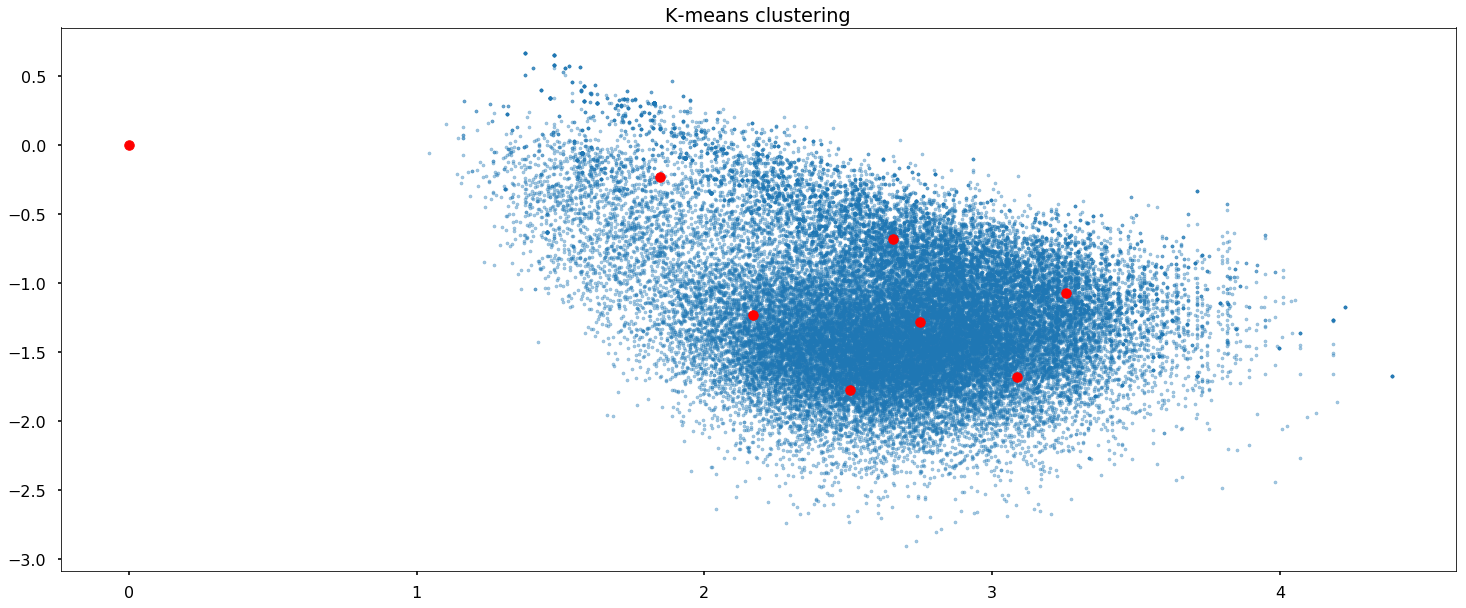

In [57]:
kmean_tfidf_w2v = kmeans(sentence_vectors_tf, 8)

In [58]:
clusters_tfidf = {i: df['bio'][np.where(kmean_tfidf_w2v.labels_ == i)[0]] for i in range(kmean_tfidf_w2v.n_clusters)}

In [59]:
clusters_tfidf[1]

2                                             CEO Flipkart
3                            Transforming e commerce India
6                           Flipkart research lab Bay Area
13                           Co founder CEO Flipkart Group
14                                  Exec Chairman Flipkart
19       A wannabe perfectionist erroneous reality Pass...
21                                                tinkerer
35                  technology music jokes anything stupid
43       I dig variety acts Pixar puppets prestidigitat...
51                                                    BASS
52                                  VP Engineering Dropbox
53                                     Luxury Bike Rentals
54       Harley Davidson Triumph Ducati Kawasaki Benell...
55       Comedian TV personality Psychic Snapchat Chels...
65                           Social media support Flipkart
83       Flipkart Ads end end commerce advertising solu...
86       A Young Turks Weekdays Bohemian Weekender Rest.

### Word2Vec + ResultantVec

In [60]:
def embed_sentences_resultant(s):
    text_tokens = preprocess_text(s)
    word_vectors = np.zeros(300,)
    v_words = 0
    for t in text_tokens:
        if t in bio_vec.wv.vocab.keys():
            v_words+=1
            word_vectors = np.add(word_vectors, bio_vec[t])
    if len(word_vectors):
        return np.divide(word_vectors, v_words)
#         return word_vectors
    else:
        return [0, 0]

In [96]:
sentence_vectors_resultant = np.array([]).reshape(0, 300)

for index, row in df.iterrows():
    if index % 1000==0 : print("Processed: ", index)
    s_vec = embed_sentences_resultant(row['bio'])
    sentence_vectors_resultant = np.vstack((sentence_vectors_resultant, s_vec))

Processed:  0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Processed:  1000
Processed:  2000
Processed:  3000
Processed:  4000
Processed:  5000
Processed:  6000
Processed:  7000
Processed:  8000
Processed:  9000
Processed:  10000
Processed:  11000
Processed:  12000
Processed:  13000


KeyboardInterrupt: 

In [99]:
sentence_vectors_resultant = pd.DataFrame(sentence_vectors_resultant)
sentence_vectors_resultant.fillna(0, inplace=True)
sentence_vectors_resultant = np.array(sentence_vectors_resultant)

In [103]:
t1 = time()
s_tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
sentence_vectors_matrix = sentence_vectors_resultant
sentence_vectors_matrix_2d = s_tsne.fit_transform(sentence_vectors_matrix)
print("Dimension reduction Time:", time()-t1)

Dimension reduction Time: 495.7931900024414


In [107]:
df.bio[:5]

0    The book PanamaPapers b obermayer f obermaier ...
1    Growing commerce India Flipkart Passionate bui...
2                                         CEO Flipkart
3                        Transforming e commerce India
4     Welcome official Twitter account Microsoft India
Name: bio, dtype: object

In [120]:
s_points = pd.DataFrame(
    [
        (sentence, coords[0], coords[1])
        for sentence, coords in [
            (sentence, sentence_vectors_matrix_2d[i])
            for i, sentence in enumerate(df.bio[:len(sentence_vectors_matrix_2d)])
        ]
    ],
    columns=["sentence", "x", "y"]
)

In [121]:
s_points.head()

,sentence,x,y
0,The book PanamaPapers b obermayer f obermaier ...,2.199922,-3.649563
1,Growing commerce India Flipkart Passionate bui...,-0.844062,-0.913478
2,CEO Flipkart,5.668872,2.731315
3,Transforming e commerce India,-0.595177,-0.497461
4,Welcome official Twitter account Microsoft India,5.105501,4.098193


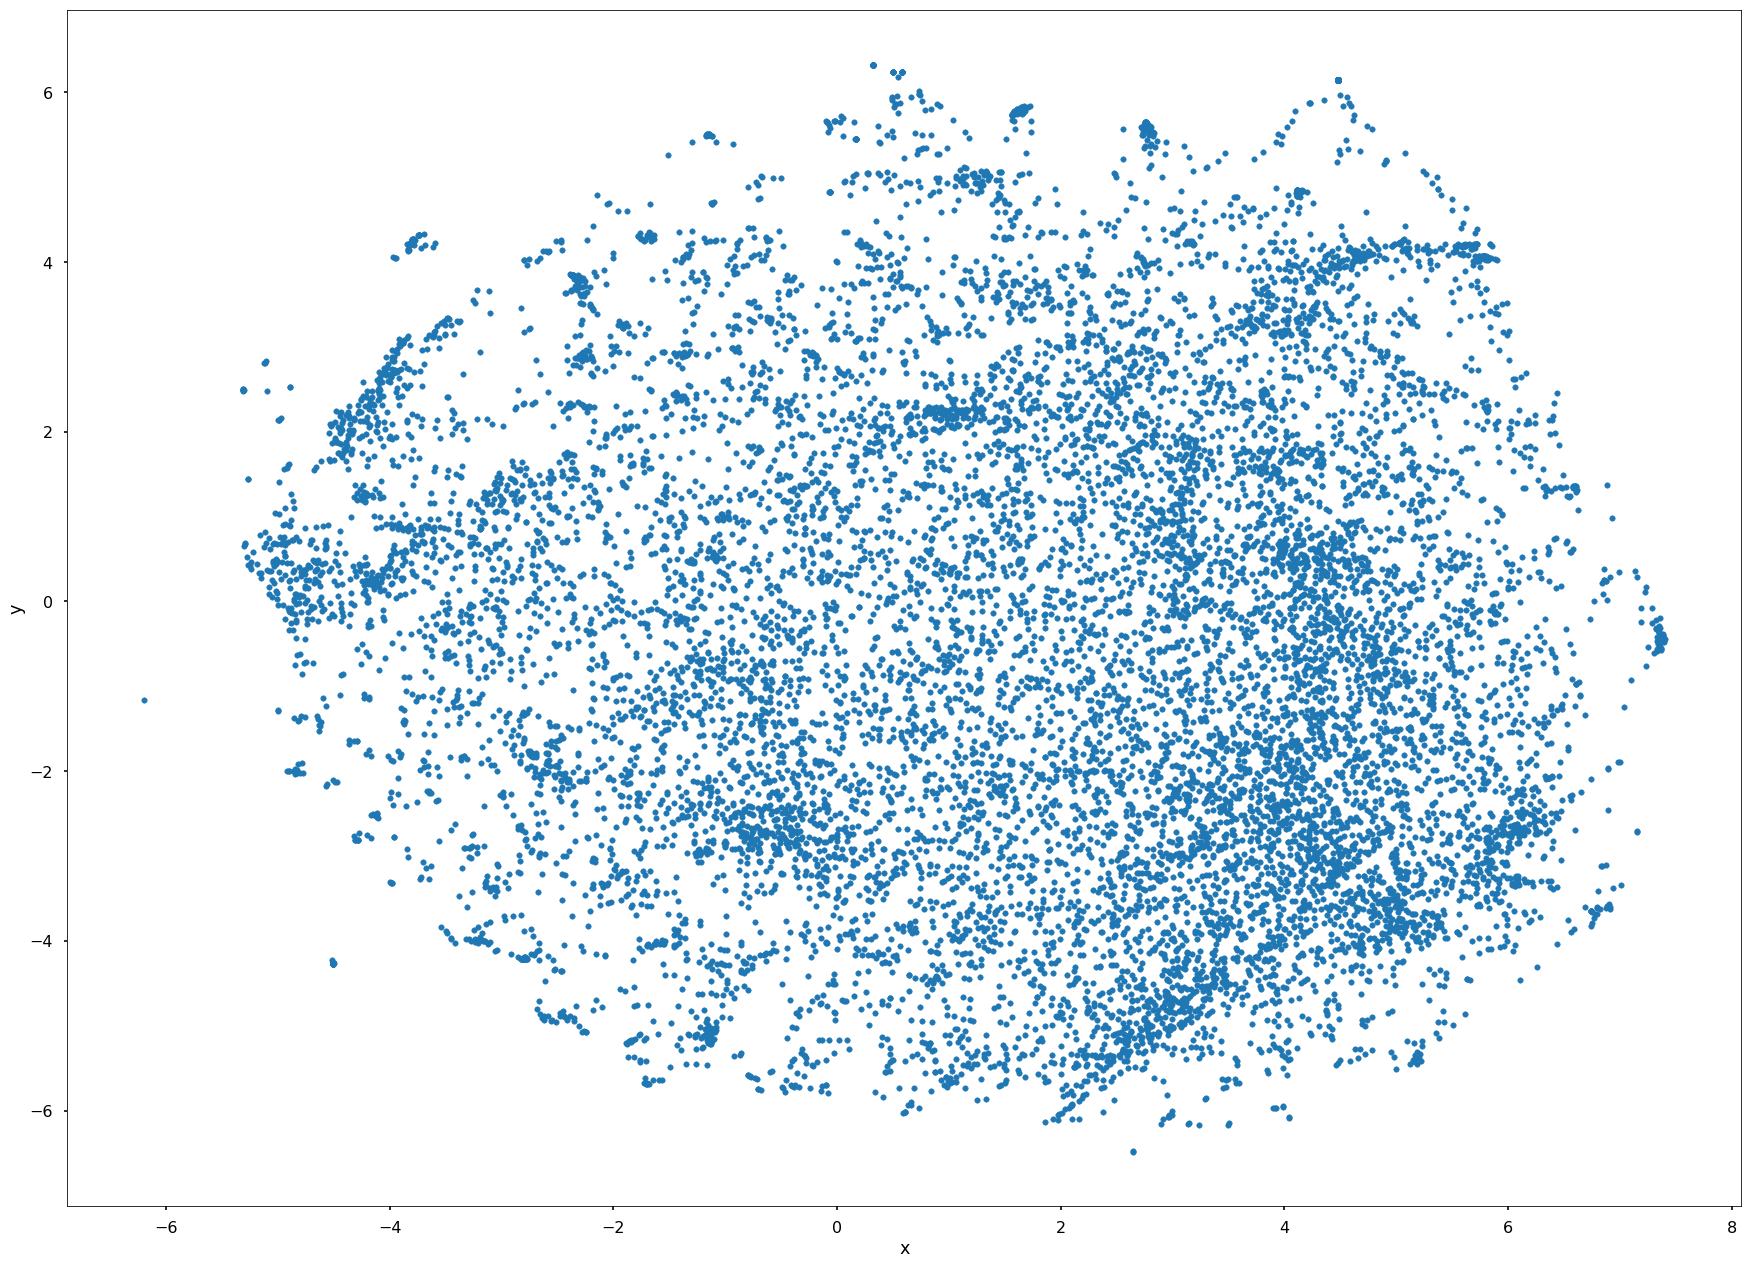

In [122]:
sns.set_context("poster")
s_points.plot.scatter("x", "y", s=30, figsize=(30, 22))
plt.show()

In [131]:
def s_plot_region(x_bounds, y_bounds):
    try:
        slice = s_points[
            (x_bounds[0] <= s_points.x) &
            (s_points.x <= x_bounds[1]) & 
            (y_bounds[0] <= s_points.y) &
            (s_points.y <= y_bounds[1])
        ]

        ax = slice.plot.scatter("x", "y", s=90, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.sentence, fontsize=11)
    except Exception as e:
        print("No word in this region", e)

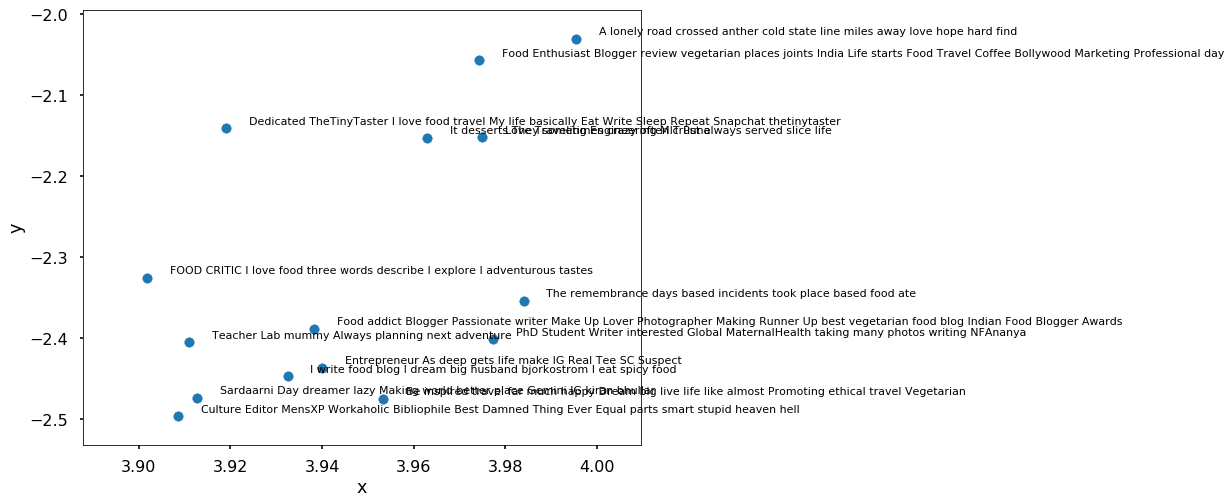

In [150]:
s_plot_region(x_bounds=(3.9, 4), y_bounds=(-2.5, -2))
plt.show()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=400, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=False)
done in 2.822s


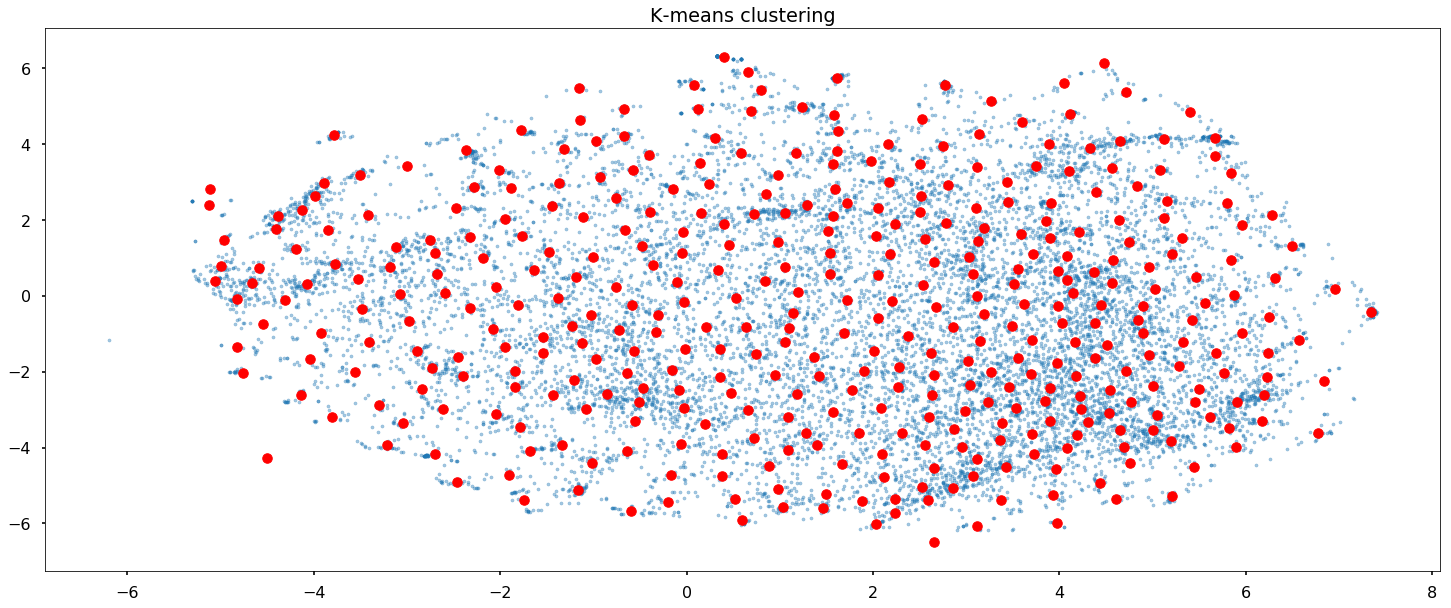

In [140]:
kmean_result = kmeans(sentence_vectors_matrix_2d, 400)

In [141]:
clusters_res = {i: df['bio'][np.where(kmean_result.labels_ == i)[0]] for i in range(kmean_result.n_clusters)}

In [144]:
clusters_res[0]

94                     Posts For author follow benthompson
606                                like know every updates
1171                             Free Online Ecards Portal
1212     Team Gautam Official Team Stylish icon gautam ...
1813                               It Electronic Discovery
2431            CGCRI one first four labs established CSIR
2794     Association International Wealth Management India
4620     Discover book access VIP airport lounges world...
5509     Facebook posts For organic feed follow ralphva...
5701     Tweets related Thailand Thai holiday destinations
5897     Bundi Haveli heritage property heart old city ...
6241     The iconic NEYLA Mediterranean Bistro Georgeto...
6464                       Tweet Niume Posts account share
7154     Precise Resort Marina Wolfsbruch Hotel Feriena...
7183     Escape Vdara Hotel Spa breathtaking eco friend...
7206                                        A lady seasons
7370                              preferred hotels resor

#### Saving Clusters Data

In [71]:
def save_clusters(cluster_t, cluster_name):
    if not os.path.exists("_data/{}".format(cluster_name)):
        os.makedirs("_data/{}".format(cluster_name))
    path = "_data/{}/".format(cluster_name)
    for i,c in enumerate(cluster_t):
        with open(path+str(i), 'a') as f:
            for t in cluster_t[c]:
                f.write(str(t))
                f.write('\n')
            f.close()
    print("Saved {}".format(cluster_name))

In [145]:
save_clusters(clusters_res, "cluster_res")

Saved cluster_res


In [73]:
save_clusters(clusters_tfidf, "cluster_tfidf")

Saved cluster_tfidf


### Semantic Clustering!

In [74]:
def semantic_score(s1, s2):
    s1p = [i for i in preprocess_text(s1) if i in bio_vec.wv.vocab]
    s2p = [i for i in preprocess_text(s2) if i in bio_vec.wv.vocab]
    if len(s1p) and len(s2p):
        return google_vec.n_similarity(s1p, s2p)
    else:
        return 0.0

In [161]:
from collections import Counter